In [1]:
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip
#For ML
import sklearn
import sklearn.naive_bayes
import sklearn.tree
import sklearn.ensemble
import sklearn.neural_network
import sklearn.decomposition

import nltk #For tokenizing and normalizing
import numpy as np #arrays
import matplotlib.pyplot as plt #Plots
import matplotlib.colors # For nice colours
import seaborn as sns #Makes plots look nice, also heatmaps
import scipy as sp #for interp

#These are from the standard library
import collections
import os
import os.path
import random
import re
import glob
import pandas as pd
import requests
import json
import math

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

In [2]:
lyrics_df = pd.read_csv('cleaned_lyrics_year.csv')
lyrics_df[:5]

year           artist genre  \
0  2009  beyonce-knowles   Pop   
1  2009  beyonce-knowles   Pop   
2  2009  beyonce-knowles   Pop   
3  2009  beyonce-knowles   Pop   
4  2009  beyonce-knowles   Pop   

                                              lyrics  \
0  oh baby, how you doing? you know i'm gonna cut...   
1  playin' everything so easy, it's like you seem...   
2  if you search for tenderness it isn't hard to ...   
3  oh oh oh i, oh oh oh i   if i wrote a book abo...   
4  party the people, the people the party it's po...   

                                          normalized  
0  ['oh', 'baby', 'know', 'be', 'gon', 'na', 'cut...  
1  ['playin', 'easy', 'like', 'sure', 'way', 'not...  
2  ['search', 'tenderness', 'hard', 'find', 'love...  
3  ['oh', 'oh', 'oh', 'oh', 'oh', 'oh', 'write', ...  
4  ['party', 'people', 'people', 'party', 'pop', ...

In [35]:
from multiprocessing import Pool,cpu_count
cpu_count()

56

In [5]:
import re
def filtering(x):
    strip_blank = re.sub('\n', ' ', x.lower())
    my_stop_words = ['intro','verse','pre','post','lift','chorus','bridge','outro',
                     '\[','\]',':',';',] + [str(i) for i in range(10)]
    regex_command = '|'.join(['('+ w + ')' for w in my_stop_words])
    regex = re.compile(regex_command)
    return re.sub(regex, '', strip_blank)

In [6]:
from multiprocessing import Pool
p = Pool(30)
lyrics_df['lyrics'] = p.map(filtering, lyrics_df['lyrics'])

In [27]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/cytwill/nltk_data...


True

In [7]:
from nltk.sentiment import SentimentIntensityAnalyzer
vader = SentimentIntensityAnalyzer()

In [8]:
#%%writefile sentiment.py
def sentiment(x):
    return vader.polarity_scores(x)['compound']

In [9]:
from multiprocessing import Pool
# sentiment analysis
p = Pool()
lyrics_df['sentiment'] = p.map(sentiment,lyrics_df['lyrics'])
lyrics_df['sentiment'][:5]

0    0.9976
1    0.9658
2    0.9696
3    0.9993
4    0.8659
Name: sentiment, dtype: float64

In [18]:
%%writefile repetity.py
import ast
import pandas as pd
def repetity(x):
    words = ast.literal_eval(x)
    return (len(words)/len(pd.unique(words)))-1

Writing repetity.py


In [10]:
from repetity import repetity
p = Pool()
lyrics_df['repetity'] = p.map(repetity,lyrics_df['normalized'])
lyrics_df['repetity'][:5]

0    1.173333
1    0.860000
2    0.266667
3    2.491803
4    6.333333
Name: repetity, dtype: float64

In [11]:
lyrics_df.to_csv('cleaned_lyrics_sentiment_repetity.csv',index=None)

In [4]:
lyrics_df = pd.read_csv('lyrics_sentiment_repetity.csv')
lyrics_df[:5]

artist genre                                             lyrics  \
0  beyonce-knowles   Pop  oh baby, how you doing? you know i'm gonna cut...   
1  beyonce-knowles   Pop  playin' everything so easy, it's like you seem...   
2  beyonce-knowles   Pop  if you search for tenderness it isn't hard to ...   
3  beyonce-knowles   Pop  oh oh oh i, oh oh oh i   if i wrote a book abo...   
4  beyonce-knowles   Pop  party the people, the people the party it's po...   

                                          normalized  sentiment  repetity  
0  ['oh', 'baby', 'know', 'be', 'gon', 'na', 'cut...     0.9976  1.173333  
1  ['playin', 'easy', 'like', 'sure', 'way', 'not...     0.9658  0.860000  
2  ['search', 'tenderness', 'hard', 'find', 'love...     0.9696  0.266667  
3  ['oh', 'oh', 'oh', 'oh', 'oh', 'oh', 'write', ...     0.9993  2.491803  
4  ['party', 'people', 'people', 'party', 'pop', ...     0.8659  6.333333

In [12]:
genre_groups = lyrics_df.groupby(['genre'])
len(genre_groups)

10

In [13]:
genre_means = genre_groups.mean()

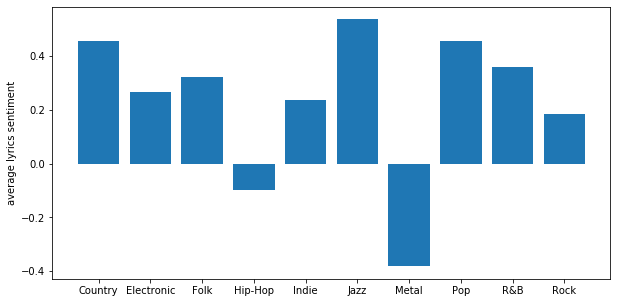

<Figure size 720x360 with 0 Axes>

In [14]:
plt.rcParams['figure.figsize']=[10,5]
plt.bar(genre_means.index, genre_means['sentiment'])
plt.ylabel('average lyrics sentiment')
plt.show()
plt.savefig('Pictures/Sentiment.png')

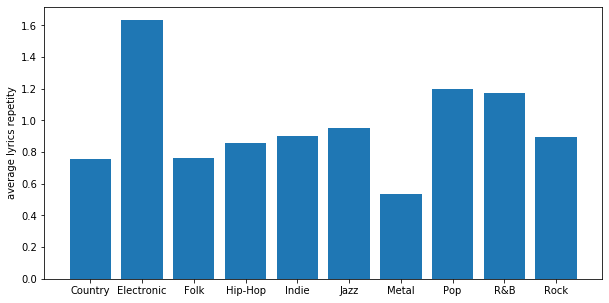

<Figure size 720x360 with 0 Axes>

In [15]:
plt.rcParams['figure.figsize']=[10,5]
plt.bar(genre_means.index, genre_means['repetity'])
plt.ylabel('average lyrics repetity')
plt.show()
plt.savefig('Pictures/Repetity.png')

## Classification Analysis
### Scenario 1. Only word frequency features

In [17]:
lyrics_df = pd.read_csv('cleaned_lyrics_sentiment_repetity.csv')
lyrics_df

year           artist    genre  \
0       2009  beyonce-knowles      Pop   
1       2009  beyonce-knowles      Pop   
2       2009  beyonce-knowles      Pop   
3       2009  beyonce-knowles      Pop   
4       2009  beyonce-knowles      Pop   
...      ...              ...      ...   
210637  2012       edens-edge  Country   
210638  2012       edens-edge  Country   
210639  2012       edens-edge  Country   
210640  2012       edens-edge  Country   
210641  2012       edens-edge  Country   

                                                   lyrics  \
0       oh baby, how you doing? you know i'm gonna cut...   
1       playin' everything so easy, it's like you seem...   
2       if you search for tenderness it isn't hard to ...   
3       oh oh oh i, oh oh oh i   if i wrote a book abo...   
4       party the people, the people the party it's po...   
...                                                   ...   
210637  i gotta say boy, after only just a couple of d...   
210638  i helped you find her diamond ring you made me...   
210639  look at the couple in the corner booth looks a...   
210640  when i fly off this mortal earth and i'm measu...   
210641  i heard from a friend of a friend of a friend ...   

                                               normalized  sentiment  repetity  
0       ['oh', 'baby', 'know', 'be', 'gon', 'na', 'cut...     0.9976  1.173333  
1       ['playin', 'easy', 'like', 'sure', 'way', 'not...     0.9658  0.860000  
2       ['search', 'tenderness', 'hard', 'find', 'love...     0.9696  0.266667  
3       ['oh', 'oh', 'oh', 'oh', 'oh', 'oh', 'write', ...     0.9993  2.491803  
4       ['party', 'people', 'people', 'party', 'pop', ...     0.8659  6.333333  
...                                                   ...        ...       ...  
210637  ['get', 'ta', 'boy', 'couple', 'date', 'hand',...     0.9545  0.987342  
210638  ['help', 'find', 'diamond', 'ring', 'try', 'to...    -0.9716  1.095238  
210639  ['look', 'couple', 'corner', 'booth', 'look', ...     0.9605  0.593220  
210640  ['fly', 'mortal', 'earth', 'be', 'measure', 'd...     0.9844  0.460000  
210641  ['hear', 'friend', 'friend', 'friend', 'finall...     0.9945  1.412698  

[210642 rows x 7 columns]

In [18]:
# code these genre names
genre_dict = {}
for i, c in enumerate(pd.unique(lyrics_df['genre'])):
    genre_dict[c] = i
genre_dict

{'Pop': 0,
 'Hip-Hop': 1,
 'Rock': 2,
 'Metal': 3,
 'Country': 4,
 'Jazz': 5,
 'Electronic': 6,
 'Folk': 7,
 'R&B': 8,
 'Indie': 9}

In [19]:
ind2cat = {v:k for k,v in genre_dict.items()}
ind2cat

{0: 'Pop',
 1: 'Hip-Hop',
 2: 'Rock',
 3: 'Metal',
 4: 'Country',
 5: 'Jazz',
 6: 'Electronic',
 7: 'Folk',
 8: 'R&B',
 9: 'Indie'}

In [20]:
lyrics_df['genre'] = lyrics_df['genre'].astype('category')
lyrics_df['genre'] = lyrics_df['genre'].apply(lambda x:genre_dict[x])

In [21]:
from sklearn.model_selection import train_test_split
# train_test split
lyrics_1_train, lyrics_1_test = train_test_split(lyrics_df, test_size=0.3, random_state=0)

In [22]:
# creating customized stop word lists
from sklearn.feature_extraction import stop_words
my_stop_words = list(stop_words.ENGLISH_STOP_WORDS)
my_stop_words += [str(i) for i in range(10)]
my_stop_words += ['intro','verse','pre','post','lift','chorus','bridge','outro','instrumental']
my_stop_words

['seems',
 'a',
 'nevertheless',
 'within',
 'off',
 'yet',
 'too',
 'whence',
 'others',
 'against',
 'front',
 'name',
 'else',
 'than',
 'may',
 'which',
 'same',
 'mostly',
 'out',
 'four',
 'also',
 'via',
 'until',
 'at',
 'is',
 'call',
 'such',
 'two',
 'we',
 'eleven',
 'done',
 'whereafter',
 'except',
 'fill',
 'besides',
 'not',
 'most',
 'after',
 'seeming',
 'without',
 'once',
 'and',
 'either',
 'throughout',
 'ourselves',
 'all',
 'none',
 'fifty',
 'on',
 'an',
 'top',
 'only',
 'neither',
 'with',
 'can',
 'were',
 'amoungst',
 'bottom',
 'system',
 'have',
 'when',
 'in',
 'herself',
 'as',
 'often',
 'seemed',
 'nor',
 'therein',
 'everything',
 'beforehand',
 'beyond',
 'you',
 'five',
 'nine',
 'therefore',
 'everyone',
 'he',
 'towards',
 'eg',
 'everywhere',
 'ever',
 'fire',
 'of',
 'down',
 'seem',
 'beside',
 'made',
 'moreover',
 'enough',
 'forty',
 'less',
 'his',
 'give',
 'through',
 'move',
 'this',
 'those',
 'due',
 'or',
 'nobody',
 'sincere',
 'alm

In [23]:
TFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.8, min_df=0.01, stop_words=my_stop_words, norm='l2')
train_vects = TFVectorizer.fit_transform(lyrics_1_train['lyrics'])
train_vects.shape

(147449, 1023)

In [24]:
test_vects = TFVectorizer.transform(lyrics_1_test['lyrics'])
test_vects.shape

(63193, 1023)

In [25]:
pca = sklearn.decomposition.PCA(n_components=10)
train_pca = pca.fit_transform(train_vects.todense())
test_pca = pca.transform(test_vects.todense())

In [26]:
#visualize TSNE
from MulticoreTSNE import MulticoreTSNE 
tsne = MulticoreTSNE(n_jobs=30)
test_tsne = tsne.fit_transform(test_pca)
test_tsne.shape

(63193, 2)

In [27]:
import joblib
joblib.dump(test_tsne, 'TSNE/test_tdidf_tsne.joblib')

['TSNE/test_tdidf_tsne.joblib']

In [28]:
test_labels = [ind2cat[g] for g in lyrics_1_test['genre']]
test_labels

['Pop',
 'R&B',
 'Rock',
 'Rock',
 'Pop',
 'Rock',
 'Rock',
 'Rock',
 'R&B',
 'Pop',
 'Pop',
 'Rock',
 'Country',
 'Electronic',
 'Rock',
 'Pop',
 'Rock',
 'Pop',
 'Rock',
 'Rock',
 'Pop',
 'Pop',
 'Rock',
 'Hip-Hop',
 'Metal',
 'Rock',
 'Country',
 'Jazz',
 'Pop',
 'Pop',
 'Pop',
 'Country',
 'Rock',
 'Rock',
 'Metal',
 'Country',
 'Hip-Hop',
 'Rock',
 'Rock',
 'Jazz',
 'Rock',
 'Rock',
 'Metal',
 'Folk',
 'Rock',
 'Pop',
 'Country',
 'Country',
 'Pop',
 'Rock',
 'Jazz',
 'Metal',
 'Hip-Hop',
 'Country',
 'Rock',
 'Pop',
 'Rock',
 'Metal',
 'Pop',
 'Country',
 'Hip-Hop',
 'Metal',
 'Pop',
 'Rock',
 'Rock',
 'Pop',
 'Rock',
 'Rock',
 'Rock',
 'Rock',
 'Country',
 'Metal',
 'Rock',
 'Country',
 'R&B',
 'Rock',
 'Rock',
 'Pop',
 'Metal',
 'Rock',
 'Hip-Hop',
 'Hip-Hop',
 'Rock',
 'Country',
 'Hip-Hop',
 'Metal',
 'Pop',
 'Pop',
 'Rock',
 'Rock',
 'Hip-Hop',
 'Rock',
 'Rock',
 'Electronic',
 'Country',
 'Rock',
 'Pop',
 'Rock',
 'Pop',
 'Rock',
 'Rock',
 'Pop',
 'Pop',
 'Pop',
 'Metal',
 

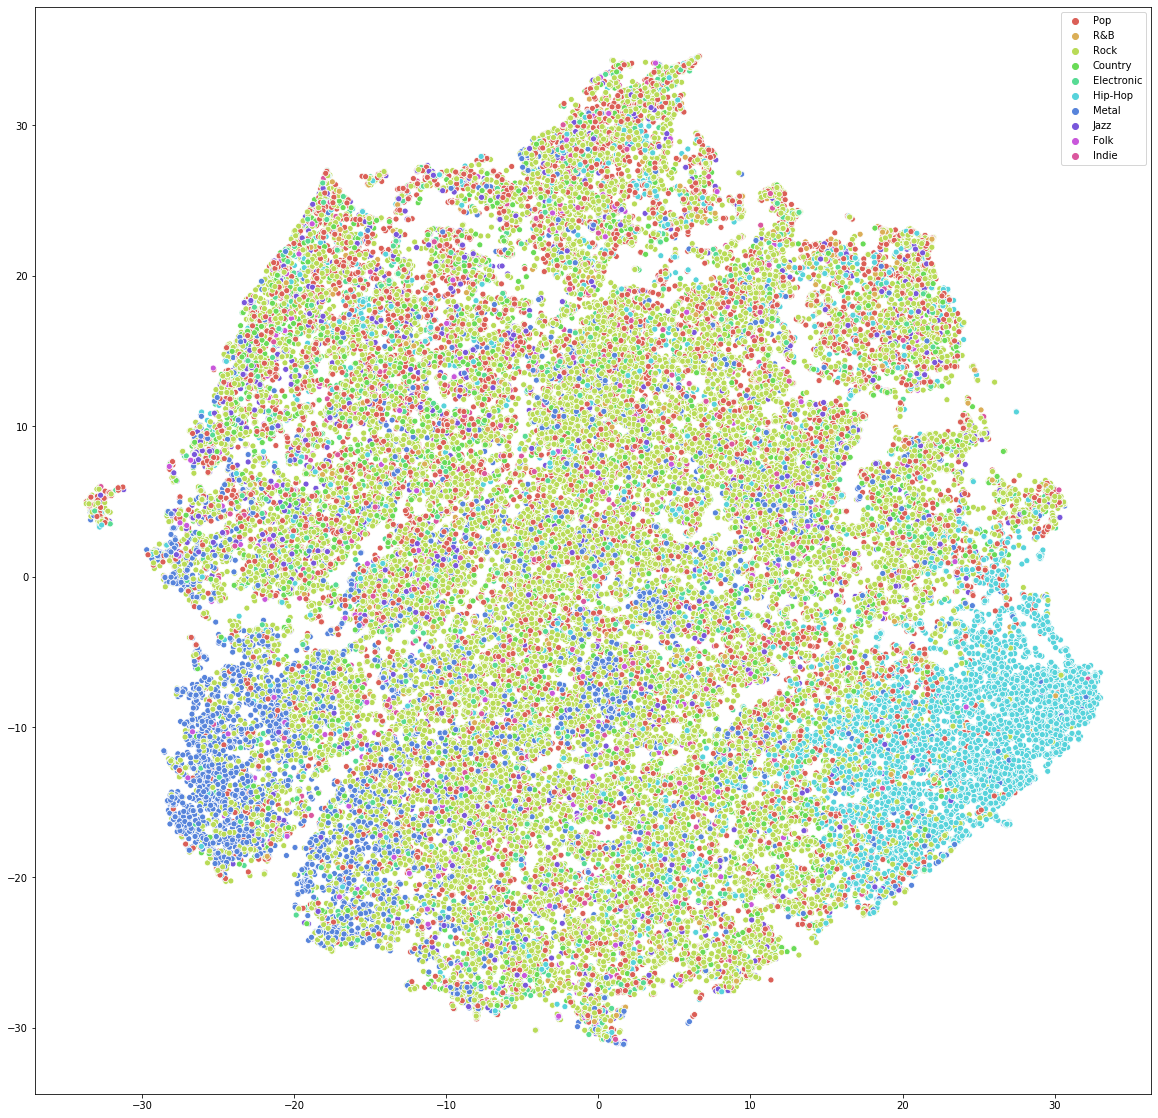

In [39]:
#original label clusters
plt.rcParams['figure.figsize']=[20,20]
ax = sns.scatterplot(test_tsne[:,0],test_tsne[:,1],hue=test_labels,
                     palette=sns.color_palette("hls", 10))
#plt.savefig('Pictures/original categories.png')

In [31]:
train_groups = lyrics_1_train.groupby(['genre'])
train_groups = dict(list(train_groups))
class_weights = {k:len(lyrics_1_train)/len(v) for k,v in train_groups.items()}
class_weights

{4: 14.898353036273619,
 6: 32.40637362637363,
 7: 125.16893039049236,
 1: 9.545478086359811,
 9: 71.1970062771608,
 5: 29.31974547623782,
 3: 10.074405575293795,
 0: 6.2238402768984,
 8: 64.4726716222125,
 2: 2.147430202583633}

In [32]:
class_bases = np.linspace(min(class_weights.values()),max(class_weights.values()),5)
class_bases

array([  2.1474302 ,  32.90280525,  63.6581803 ,  94.41355534,
       125.16893039])

In [33]:
class_weight_paras = []
for b in class_bases:
    candidate = {c:v+b for c,v in class_weights.items()}
    class_weight_paras.append(candidate)
class_weight_paras

[{4: 17.04578323885725,
  6: 34.553803828957264,
  7: 127.316360593076,
  1: 11.692908288943444,
  9: 73.34443647974443,
  5: 31.46717567882145,
  3: 12.221835777877429,
  0: 8.371270479482034,
  8: 66.62010182479614,
  2: 4.294860405167266},
 {4: 47.80115828583443,
  6: 65.30917887593444,
  7: 158.0717356400532,
  1: 42.44828333592062,
  9: 104.09981152672161,
  5: 62.222550725798634,
  3: 42.97721082485461,
  0: 39.126645526459214,
  8: 97.37547687177332,
  2: 35.05023545214445},
 {4: 78.55653333281163,
  6: 96.06455392291163,
  7: 188.82711068703037,
  1: 73.20365838289781,
  9: 134.8551865736988,
  5: 92.97792577277582,
  3: 73.73258587183179,
  0: 69.88202057343639,
  8: 128.1308519187505,
  2: 65.80561049912163},
 {4: 109.3119083797888,
  6: 126.81992896988882,
  7: 219.58248573400755,
  1: 103.95903342987499,
  9: 165.61056162067598,
  5: 123.733300819753,
  3: 104.48796091880898,
  0: 100.63739562041359,
  8: 158.8862269657277,
  2: 96.56098554609882},
 {4: 140.06728342676598,


In [34]:
# calculating sample weights for imbalanced sample
from sklearn.utils.class_weight import compute_sample_weight
train_sample_weights = compute_sample_weight(class_weight='balanced', y=lyrics_1_train['genre'])
train_sample_weights

array([0.62238403, 0.21474302, 0.62238403, ..., 0.21474302, 0.21474302,
       1.00744056])

In [35]:
sample_bases = np.linspace(min(train_sample_weights),max(train_sample_weights),5)
sample_weight_paras = [train_sample_weights + x for x in sample_bases]
sample_weight_paras

[array([0.83712705, 0.42948604, 0.83712705, ..., 0.42948604, 0.42948604,
        1.22218358]),
 array([3.91266455, 3.50502355, 3.91266455, ..., 3.50502355, 3.50502355,
        4.29772108]),
 array([6.98820206, 6.58056105, 6.98820206, ..., 6.58056105, 6.58056105,
        7.37325859]),
 array([10.06373956,  9.65609855, 10.06373956, ...,  9.65609855,
         9.65609855, 10.44879609]),
 array([13.13927707, 12.73163606, 13.13927707, ..., 12.73163606,
        12.73163606, 13.5243336 ])]

In [36]:
classifiers = {'NaiveBayes':sklearn.naive_bayes.GaussianNB(),
               'LogisticRegression':sklearn.linear_model.LogisticRegression(n_jobs=-1),
               'RandomForest':sklearn.ensemble.RandomForestClassifier(n_jobs=-1),
               }
from sklearn.model_selection import GridSearchCV
parameters = {'NaiveBayes':{'var_smoothing':10**np.linspace(-20,-10,5)},
              'LogisticRegression':{'C':10**np.linspace(-2,2,5),'class_weight':class_weight_paras},
              'RandomForest':{"max_depth":np.linspace(1,10,4),'class_weight':class_weight_paras},
             }

In [37]:
f1_scorer = sklearn.metrics.make_scorer(sklearn.metrics.f1_score,average='weighted')

In [38]:
s2_df = pd.DataFrame(columns=['clf',
                              #'test_ave_5','test_acc_5','test_roc_5',
                              'test_f1_base','test_acc_base','test_roc_base',
                              'test_f1_senti','test_acc_senti','test_roc_senti',
                              'test_f1_rep','test_acc_rep','test_roc_rep',
                              'test_f1_both','test_acc_both','test_roc_both'])
s2_df

Empty DataFrame
Columns: [clf, test_f1_base, test_acc_base, test_roc_base, test_f1_senti, test_acc_senti, test_roc_senti, test_f1_rep, test_acc_rep, test_roc_rep, test_f1_both, test_acc_both, test_roc_both]
Index: []

In [40]:
# test for PCs
best_clfs = {}
i = 0
for k in classifiers:
    clf = GridSearchCV(estimator=classifiers[k], param_grid=parameters[k], scoring=f1_scorer, n_jobs=-1, cv=10)
    if k == "NaiveBayes":
        clf.fit(train_pca, lyrics_1_train['genre'], sample_weight=sample_weight_paras[2])
    else:
        clf.fit(train_pca, lyrics_1_train['genre'])
    s2_df.loc[i,'clf'] = k
    s2_df.loc[i,'test_f1_base'] = clf.score(test_pca, lyrics_1_test['genre'])
    s2_df.loc[i,'test_acc_base'] = sklearn.metrics.accuracy_score(lyrics_1_test['genre'],clf.predict(test_pca))                                                                                         
    s2_df.loc[i,'test_roc_base'] = sklearn.metrics.roc_auc_score(
        lyrics_1_test['genre'], clf.predict_proba(test_pca), multi_class='ovo')
    best_clfs[k] = clf.best_estimator_
    i += 1
    print("done {}".format(k))   
s2_df

done NaiveBayes
done LogisticRegression


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest


clf test_f1_base test_acc_base test_roc_base test_f1_senti  \
0          NaiveBayes     0.396593      0.418512      0.670005           NaN   
1  LogisticRegression     0.461241      0.549539      0.705788           NaN   
2        RandomForest     0.469076      0.500688      0.723143           NaN   

  test_acc_senti test_roc_senti test_f1_rep test_acc_rep test_roc_rep  \
0            NaN            NaN         NaN          NaN          NaN   
1            NaN            NaN         NaN          NaN          NaN   
2            NaN            NaN         NaN          NaN          NaN   

  test_f1_both test_acc_both test_roc_both  
0          NaN           NaN           NaN  
1          NaN           NaN           NaN  
2          NaN           NaN           NaN

### Scenario 2. word frequency + sentiment

In [41]:
train_sentiment_pca = np.append(train_pca,lyrics_1_train['sentiment'].values.reshape(len(lyrics_1_train),1), 
                                axis=1)
test_sentiment_pca = np.append(test_pca,lyrics_1_test['sentiment'].values.reshape(len(lyrics_1_test),1),
                               axis=1)
train_sentiment_pca.shape

(147449, 11)

In [42]:
best_sentiment_clfs = {}
i = 0
for k in classifiers:
    clf = GridSearchCV(estimator=classifiers[k], param_grid=parameters[k], scoring=f1_scorer, n_jobs=-1, cv=10)
    if k == "NaiveBayes":
        clf.fit(train_sentiment_pca, lyrics_1_train['genre'], sample_weight=sample_weight_paras[2])
    else:
        clf.fit(train_sentiment_pca, lyrics_1_train['genre'])
    s2_df.loc[i,'clf'] = k
    s2_df.loc[i,'test_f1_senti'] = clf.score(test_sentiment_pca, lyrics_1_test['genre'])
    s2_df.loc[i,'test_acc_senti'] = sklearn.metrics.accuracy_score(lyrics_1_test['genre'],clf.predict(test_sentiment_pca))                                                                                         
    s2_df.loc[i,'test_roc_senti'] = sklearn.metrics.roc_auc_score(
        lyrics_1_test['genre'], clf.predict_proba(test_sentiment_pca), multi_class='ovo')
    best_sentiment_clfs[k] = clf.best_estimator_
    i += 1
    print("done {}".format(k))   
s2_df

done NaiveBayes
done LogisticRegression


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest


clf test_f1_base test_acc_base test_roc_base test_f1_senti  \
0          NaiveBayes     0.396593      0.418512      0.670005       0.40839   
1  LogisticRegression     0.461241      0.549539      0.705788      0.463302   
2        RandomForest     0.469076      0.500688      0.723143      0.476725   

  test_acc_senti test_roc_senti test_f1_rep test_acc_rep test_roc_rep  \
0       0.433149        0.67443         NaN          NaN          NaN   
1       0.550868        0.70815         NaN          NaN          NaN   
2       0.506512       0.728382         NaN          NaN          NaN   

  test_f1_both test_acc_both test_roc_both  
0          NaN           NaN           NaN  
1          NaN           NaN           NaN  
2          NaN           NaN           NaN

In [88]:
sentiment_tsne = tsne.fit_transform(test_sentiment_pca)
sentiment_tsne.shape

(68020, 2)

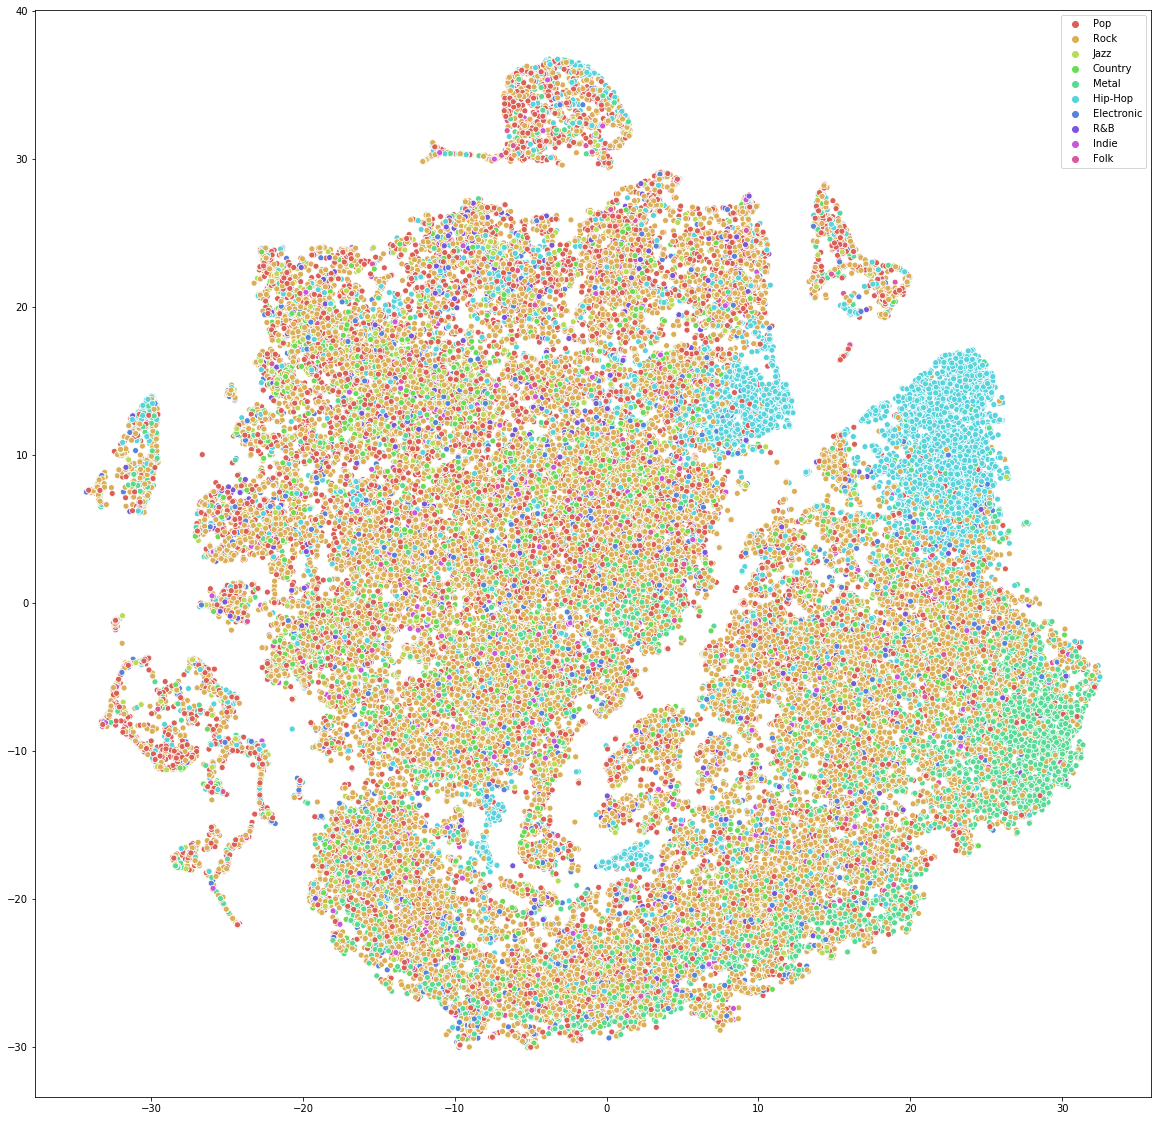

In [89]:
plt.rcParams['figure.figsize']=[20,20]
ax = sns.scatterplot(sentiment_tsne[:,0],sentiment_tsne[:,1],hue=test_labels,
                     palette=sns.color_palette("hls", 10))
plt.savefig('Pictures/sentiment categories.png')

### Scenario 3. word frequency + repetity

In [43]:
train_repetity_pca = np.append(train_pca,lyrics_1_train['repetity'].values.reshape(len(lyrics_1_train),1), 
                                axis=1)
test_repetity_pca = np.append(test_pca,lyrics_1_test['repetity'].values.reshape(len(lyrics_1_test),1),
                               axis=1)
train_repetity_pca.shape

(147449, 11)

In [44]:
best_repetity_clfs = {}
i = 0
for k in classifiers:
    clf = GridSearchCV(estimator=classifiers[k], param_grid=parameters[k], scoring=f1_scorer, n_jobs=-1, cv=10)
    if k == "NaiveBayes":
        clf.fit(train_repetity_pca, lyrics_1_train['genre'], sample_weight=sample_weight_paras[2])
    else:
        clf.fit(train_repetity_pca, lyrics_1_train['genre'])
    s2_df.loc[i,'clf'] = k
    s2_df.loc[i,'test_f1_rep'] = clf.score(test_repetity_pca, lyrics_1_test['genre'])
    s2_df.loc[i,'test_acc_rep'] = sklearn.metrics.accuracy_score(lyrics_1_test['genre'],clf.predict(test_repetity_pca))                                                                                         
    s2_df.loc[i,'test_roc_rep'] = sklearn.metrics.roc_auc_score(
        lyrics_1_test['genre'], clf.predict_proba(test_repetity_pca), multi_class='ovo')
    best_repetity_clfs[k] = clf.best_estimator_
    i += 1
    print("done {}".format(k))   
s2_df

done NaiveBayes


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done LogisticRegression


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest


clf test_f1_base test_acc_base test_roc_base test_f1_senti  \
0          NaiveBayes     0.396593      0.418512      0.670005       0.40839   
1  LogisticRegression     0.461241      0.549539      0.705788      0.463302   
2        RandomForest     0.469076      0.500688      0.723143      0.476725   

  test_acc_senti test_roc_senti test_f1_rep test_acc_rep test_roc_rep  \
0       0.433149        0.67443    0.401252     0.416723     0.679581   
1       0.550868        0.70815    0.468284     0.553115     0.715055   
2       0.506512       0.728382    0.481659     0.501464      0.73176   

  test_f1_both test_acc_both test_roc_both  
0          NaN           NaN           NaN  
1          NaN           NaN           NaN  
2          NaN           NaN           NaN

In [90]:
repetity_tsne = tsne.fit_transform(test_repetity_pca)
repetity_tsne.shape

(68020, 2)

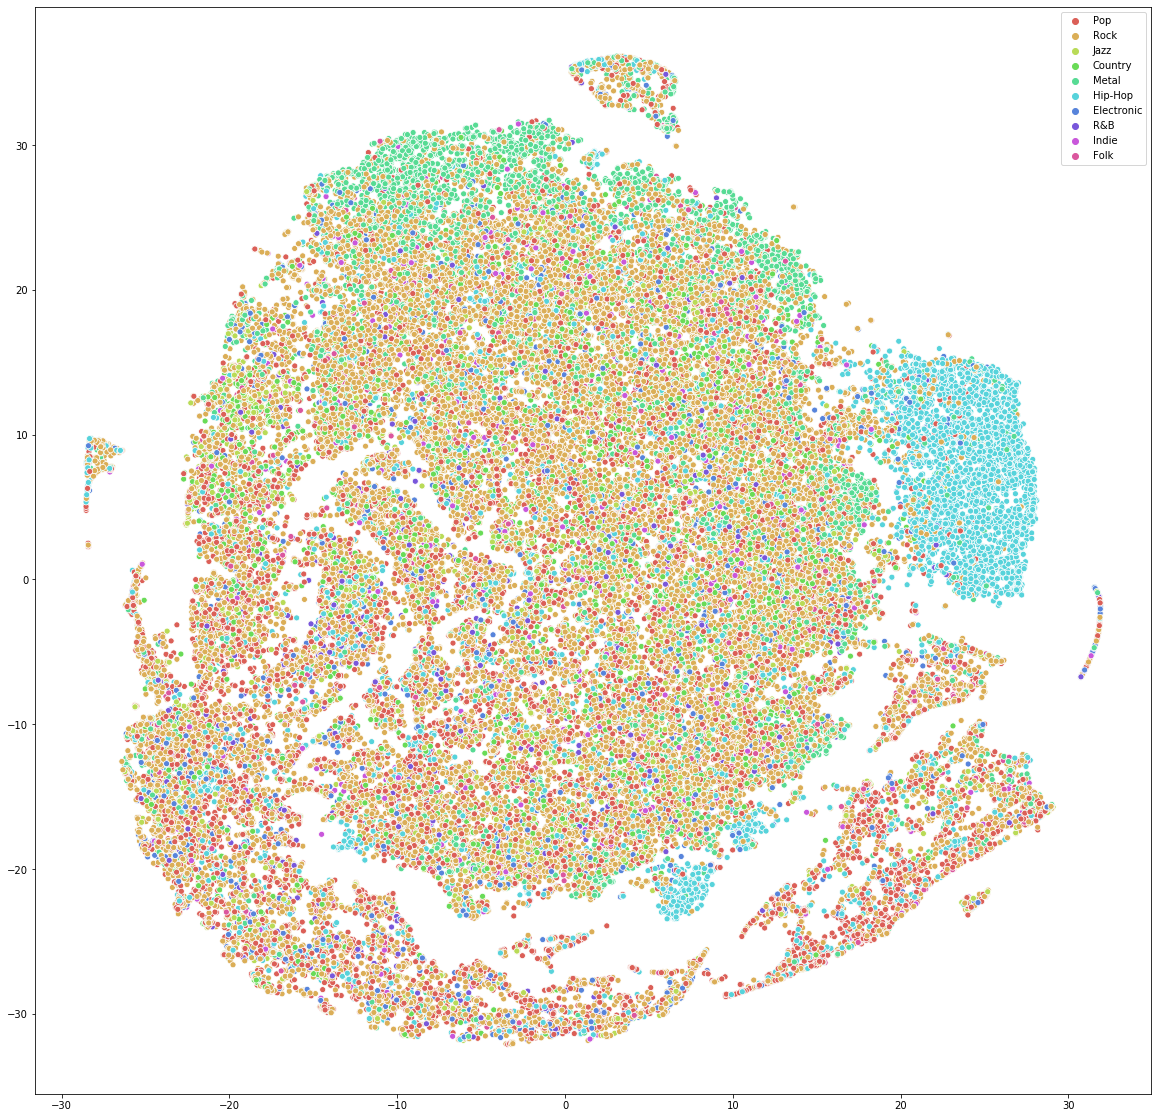

In [91]:
plt.rcParams['figure.figsize']=[20,20]
ax = sns.scatterplot(repetity_tsne[:,0],repetity_tsne[:,1],hue=test_labels,
                     palette=sns.color_palette("hls", 10))
plt.savefig('Pictures/repetity categories.png')

### Scenario 4. word frequency + both 

In [45]:
train_both_pca = np.append(train_repetity_pca,lyrics_1_train['sentiment'].values.reshape(len(lyrics_1_train),1), 
                                axis=1)
test_both_pca = np.append(test_repetity_pca,lyrics_1_test['sentiment'].values.reshape(len(lyrics_1_test),1),
                               axis=1)
train_both_pca.shape

(147449, 12)

In [46]:
best_both_clfs = {}
i = 0
for k in classifiers:
    clf = GridSearchCV(estimator=classifiers[k], param_grid=parameters[k], scoring=f1_scorer, n_jobs=-1, cv=10)
    if k == "NaiveBayes":
        clf.fit(train_both_pca, lyrics_1_train['genre'], sample_weight=sample_weight_paras[2])
    else:
        clf.fit(train_both_pca, lyrics_1_train['genre'])
    s2_df.loc[i,'clf'] = k
    s2_df.loc[i,'test_f1_both'] = clf.score(test_both_pca, lyrics_1_test['genre'])
    s2_df.loc[i,'test_acc_both'] = sklearn.metrics.accuracy_score(lyrics_1_test['genre'],clf.predict(test_both_pca))                                                                                         
    s2_df.loc[i,'test_roc_both'] = sklearn.metrics.roc_auc_score(
        lyrics_1_test['genre'], clf.predict_proba(test_both_pca), multi_class='ovo')
    best_both_clfs[k] = clf.best_estimator_
    i += 1
    print("done {}".format(k))   
s2_df

done NaiveBayes


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done LogisticRegression


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest


clf test_f1_base test_acc_base test_roc_base test_f1_senti  \
0          NaiveBayes     0.396593      0.418512      0.670005       0.40839   
1  LogisticRegression     0.461241      0.549539      0.705788      0.463302   
2        RandomForest     0.469076      0.500688      0.723143      0.476725   

  test_acc_senti test_roc_senti test_f1_rep test_acc_rep test_roc_rep  \
0       0.433149        0.67443    0.401252     0.416723     0.679581   
1       0.550868        0.70815    0.468284     0.553115     0.715055   
2       0.506512       0.728382    0.481659     0.501464      0.73176   

  test_f1_both test_acc_both test_roc_both  
0     0.411645      0.428149      0.684152  
1     0.471155      0.553036      0.717393  
2     0.484368       0.50322      0.736925

In [47]:
both_tsne = tsne.fit_transform(test_both_pca)
both_tsne.shape

(63193, 2)

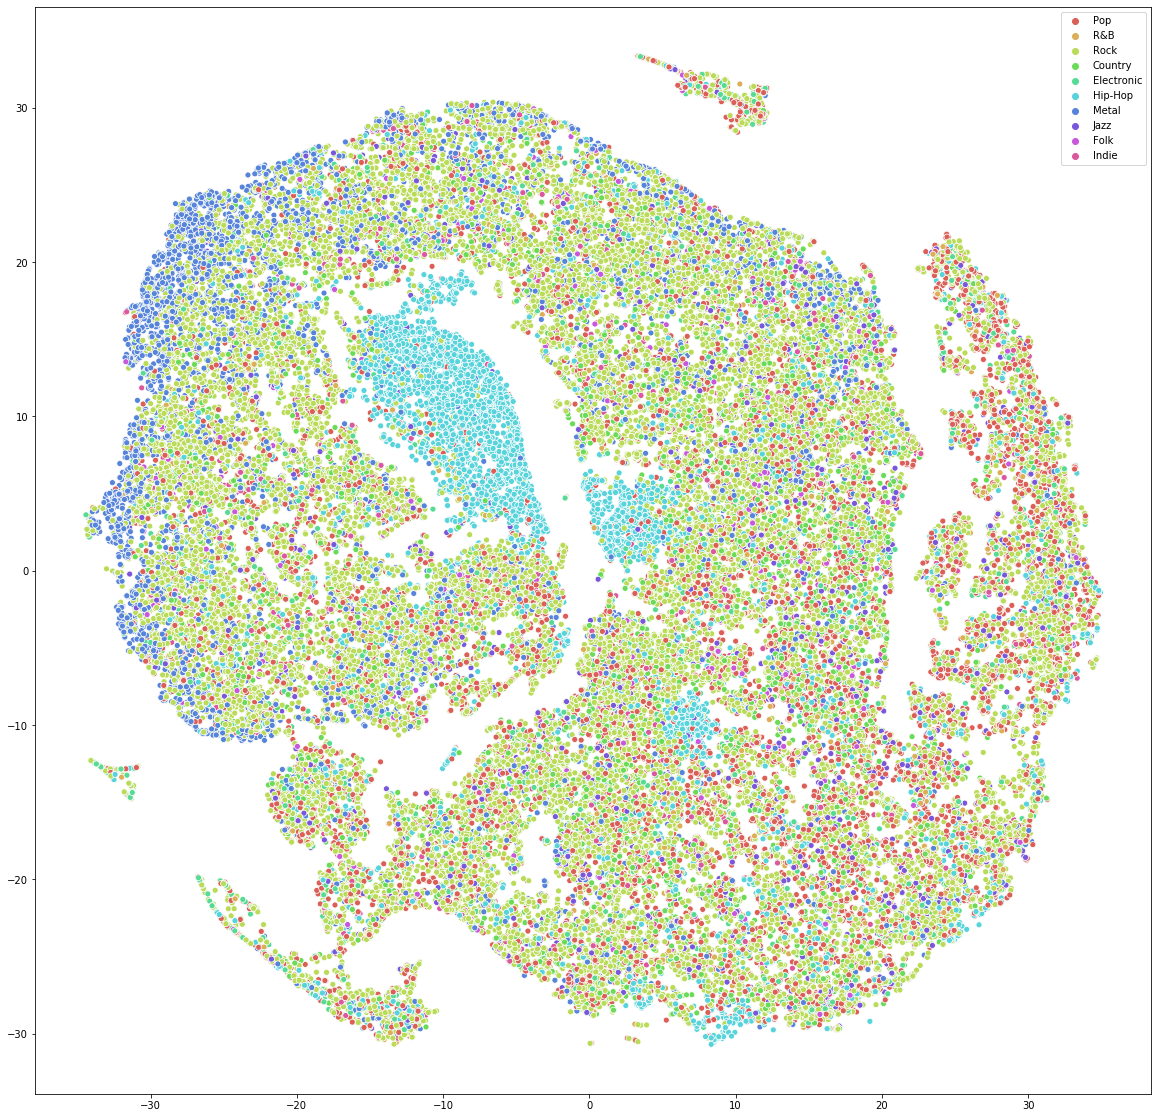

In [49]:
plt.rcParams['figure.figsize']=[20,20]
ax = sns.scatterplot(both_tsne[:,0],both_tsne[:,1],hue=test_labels,
                     palette=sns.color_palette("hls", 10))
plt.savefig('Pictures/both categories.png')

In [50]:
s2_df.to_csv('s2_result.csv', index=None)

### Single Test

In [51]:
s3_df = pd.DataFrame(columns=['clf',
                              #'test_ave_5','test_acc_5','test_roc_5',
                              'test_f1_sentiment','test_acc_sentiment','test_roc_sentiment',
                              'test_f1_repetity','test_acc_repetity','test_roc_repetity',
                              'test_f1_both','test_acc_both','test_roc_both'])
s3_df

Empty DataFrame
Columns: [clf, test_f1_sentiment, test_acc_sentiment, test_roc_sentiment, test_f1_repetity, test_acc_repetity, test_roc_repetity, test_f1_both, test_acc_both, test_roc_both]
Index: []

In [52]:
sentiment_clfs = {}
i = 0
for k in classifiers:
    clf = GridSearchCV(estimator=classifiers[k], param_grid=parameters[k], scoring=f1_scorer, n_jobs=-1, cv=10)
    if k == "NaiveBayes":
        clf.fit(lyrics_1_train['sentiment'].values.reshape(-1,1), 
                lyrics_1_train['genre'], sample_weight=sample_weight_paras[2])
    else:
        clf.fit(lyrics_1_train['sentiment'].values.reshape(-1,1), lyrics_1_train['genre'])
    s3_df.loc[i,'clf'] = k
    s3_df.loc[i,'test_f1_sentiment'] = clf.score(lyrics_1_test['sentiment'].values.reshape(-1,1), 
                                                 lyrics_1_test['genre'])
    s3_df.loc[i,'test_acc_sentiment'] = sklearn.metrics.accuracy_score(lyrics_1_test['genre'], 
                                        clf.predict(lyrics_1_test['sentiment'].values.reshape(-1,1)))                                                                                         
    s3_df.loc[i,'test_roc_sentiment'] = sklearn.metrics.roc_auc_score(lyrics_1_test['genre'], 
            clf.predict_proba(lyrics_1_test['sentiment'].values.reshape(-1,1)), multi_class='ovo')
    sentiment_clfs[k] = clf.best_estimator_
    i += 1
    print("done {}".format(k))   
s3_df

done NaiveBayes
done LogisticRegression


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest


clf test_f1_sentiment test_acc_sentiment test_roc_sentiment  \
0          NaiveBayes          0.300277           0.469751           0.582951   
1  LogisticRegression          0.300277           0.469751           0.583318   
2        RandomForest          0.378074           0.429699           0.603503   

  test_f1_repetity test_acc_repetity test_roc_repetity test_f1_both  \
0              NaN               NaN               NaN          NaN   
1              NaN               NaN               NaN          NaN   
2              NaN               NaN               NaN          NaN   

  test_acc_both test_roc_both  
0           NaN           NaN  
1           NaN           NaN  
2           NaN           NaN

In [54]:
repetity_clfs = {}
i = 0
for k in classifiers:
    clf = GridSearchCV(estimator=classifiers[k], param_grid=parameters[k], scoring=f1_scorer, n_jobs=-1, cv=10)
    if k == "NaiveBayes":
        clf.fit(lyrics_1_train['repetity'].values.reshape(-1,1), 
                lyrics_1_train['genre'], sample_weight=sample_weight_paras[2])
    else:
        clf.fit(lyrics_1_train['repetity'].values.reshape(-1,1), lyrics_1_train['genre'])
    s3_df.loc[i,'clf'] = k
    s3_df.loc[i,'test_f1_repetity'] = clf.score(lyrics_1_test['repetity'].values.reshape(-1,1), 
                                                 lyrics_1_test['genre'])
    s3_df.loc[i,'test_acc_repetity'] = sklearn.metrics.accuracy_score(lyrics_1_test['genre'], 
                                        clf.predict(lyrics_1_test['repetity'].values.reshape(-1,1)))                                                                                         
    s3_df.loc[i,'test_roc_repetity'] = sklearn.metrics.roc_auc_score(lyrics_1_test['genre'], 
            clf.predict_proba(lyrics_1_test['repetity'].values.reshape(-1,1)), multi_class='ovo')
    repetity_clfs[k] = clf.best_estimator_
    i += 1
    print("done {}".format(k))   
s3_df

done NaiveBayes
done LogisticRegression


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest


clf test_f1_sentiment test_acc_sentiment test_roc_sentiment  \
0          NaiveBayes          0.300277           0.469751           0.582951   
1  LogisticRegression          0.300277           0.469751           0.583318   
2        RandomForest          0.378074           0.429699           0.603503   

  test_f1_repetity test_acc_repetity test_roc_repetity test_f1_both  \
0         0.308899          0.464244          0.557555          NaN   
1         0.330075          0.418575          0.572891          NaN   
2         0.352927          0.398414          0.594483          NaN   

  test_acc_both test_roc_both  
0           NaN           NaN  
1           NaN           NaN  
2           NaN           NaN

In [55]:
both_clfs = {}
i = 0
for k in classifiers:
    clf = GridSearchCV(estimator=classifiers[k], param_grid=parameters[k], scoring=f1_scorer, n_jobs=-1, cv=10)
    if k == "NaiveBayes":
        clf.fit(lyrics_1_train[['repetity','sentiment']], 
                lyrics_1_train['genre'], sample_weight=sample_weight_paras[2])
    else:
        clf.fit(lyrics_1_train[['repetity','sentiment']], 
                lyrics_1_train['genre'])
    s3_df.loc[i,'clf'] = k
    s3_df.loc[i,'test_f1_both'] = clf.score(lyrics_1_test[['repetity','sentiment']], 
                                        lyrics_1_test['genre'])
    s3_df.loc[i,'test_acc_both'] = sklearn.metrics.accuracy_score(lyrics_1_test['genre'], 
                            clf.predict(lyrics_1_test[['repetity','sentiment']]))                                                                                         
    s3_df.loc[i,'test_roc_both'] = sklearn.metrics.roc_auc_score(lyrics_1_test['genre'], 
    clf.predict_proba(lyrics_1_test[['repetity','sentiment']]), multi_class='ovo')
    both_clfs[k] = clf.best_estimator_
    i += 1
    print("done {}".format(k))   
s3_df

done NaiveBayes


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done LogisticRegression


/home/cytwill/.local/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


done RandomForest


clf test_f1_sentiment test_acc_sentiment test_roc_sentiment  \
0          NaiveBayes          0.300277           0.469751           0.582951   
1  LogisticRegression          0.300277           0.469751           0.583318   
2        RandomForest          0.378074           0.429699           0.603503   

  test_f1_repetity test_acc_repetity test_roc_repetity test_f1_both  \
0         0.308899          0.464244          0.557555     0.314658   
1         0.330075          0.418575          0.572891      0.34159   
2         0.352927          0.398414          0.594483     0.395977   

  test_acc_both test_roc_both  
0      0.465178      0.606326  
1      0.407656       0.61256  
2        0.4203       0.64091

In [56]:
s3_df.to_csv('s3_result.csv', index=None)

### Feature Analysis

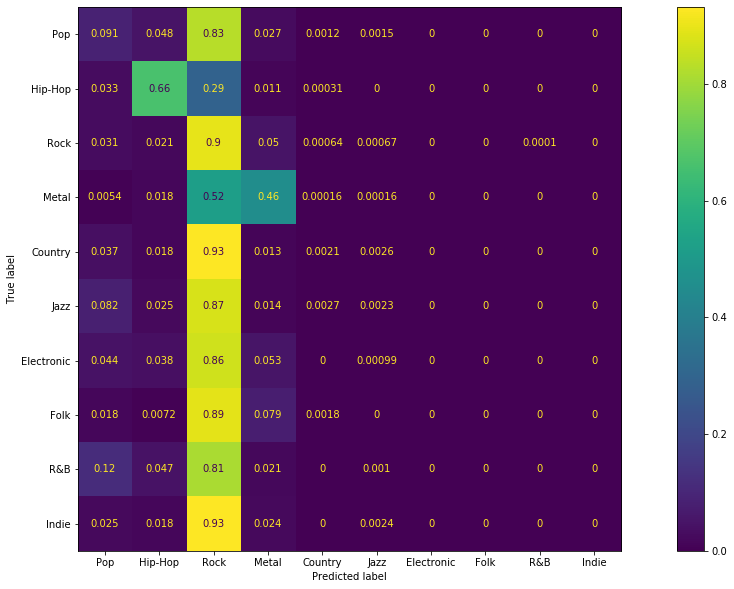

In [57]:
plt.rcParams['figure.figsize'] = [20,10]
sklearn.metrics.plot_confusion_matrix(best_clfs['LogisticRegression'], 
                                      test_pca, lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_logistic_regression_base')

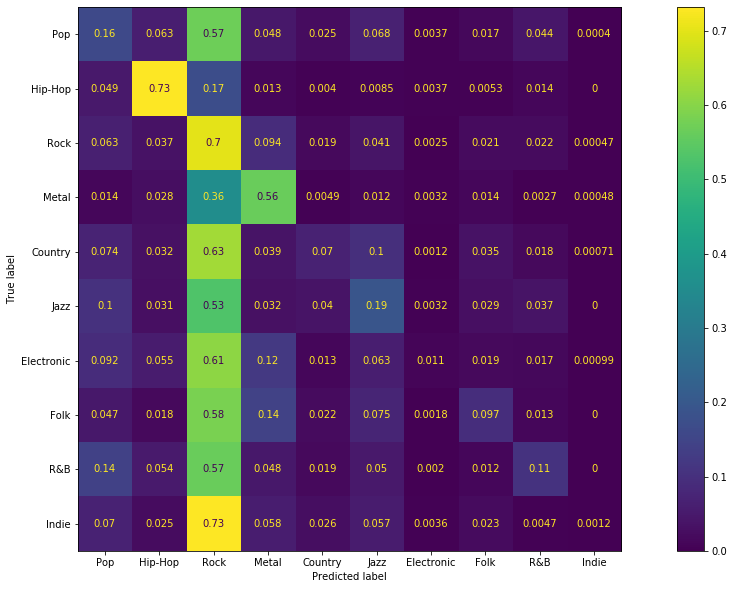

In [65]:
plt.rcParams['figure.figsize'] = [20,10]
sklearn.metrics.plot_confusion_matrix(best_clfs['RandomForest'], 
                                      test_pca, lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_random_forest_base')

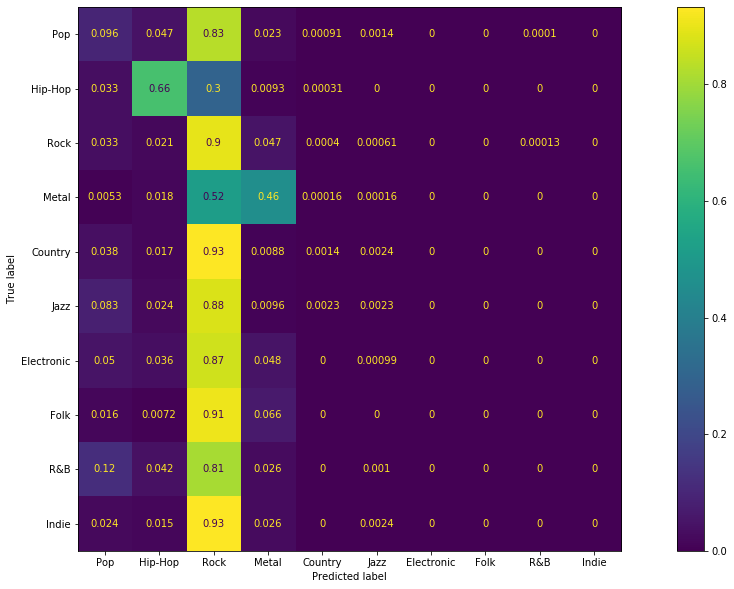

In [58]:
plt.rcParams['figure.figsize'] = [20,10]
sklearn.metrics.plot_confusion_matrix(best_sentiment_clfs['LogisticRegression'], 
                                      test_sentiment_pca, lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_logistic_regression_sentiment')

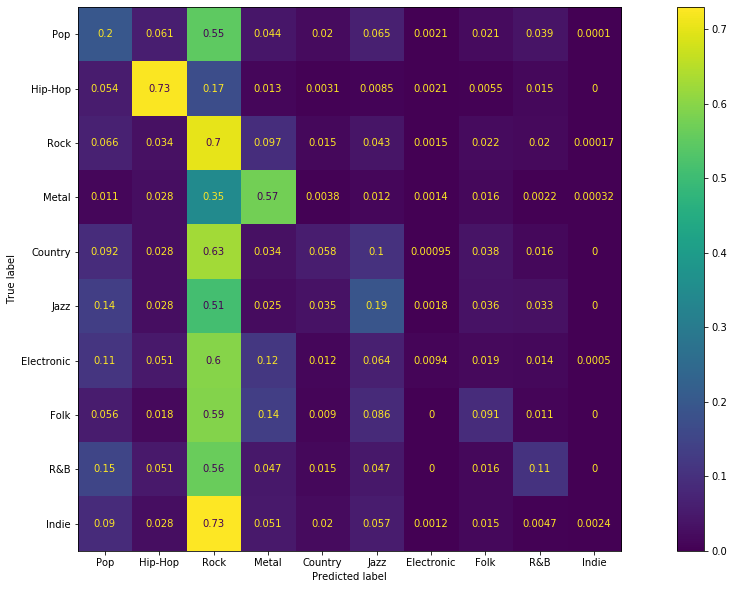

In [67]:
plt.rcParams['figure.figsize'] = [20,10]
sklearn.metrics.plot_confusion_matrix(best_sentiment_clfs['RandomForest'], 
                                      test_sentiment_pca, lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_random_forest_sentiment')

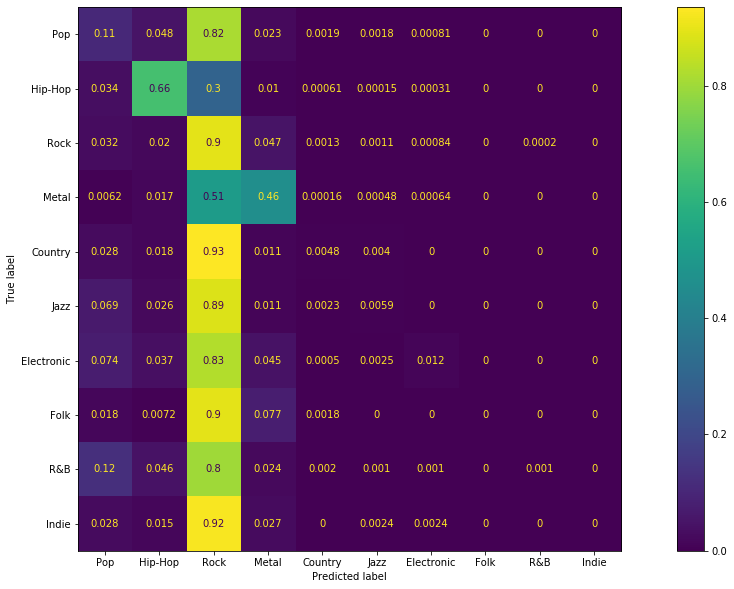

In [59]:
sklearn.metrics.plot_confusion_matrix(best_repetity_clfs['LogisticRegression'], 
                                      test_repetity_pca, lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_logistic_regression_repetity')

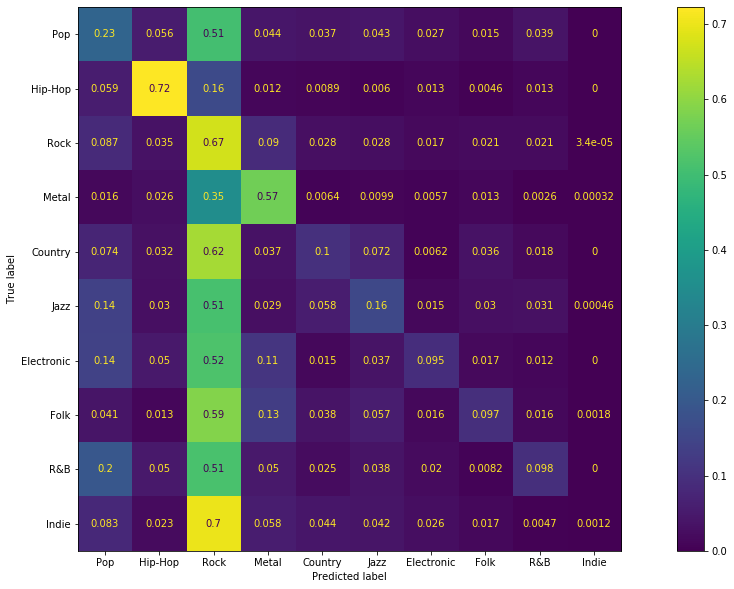

In [69]:
sklearn.metrics.plot_confusion_matrix(best_repetity_clfs['RandomForest'], 
                                      test_repetity_pca, lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_logistic_random_forest_repetity')

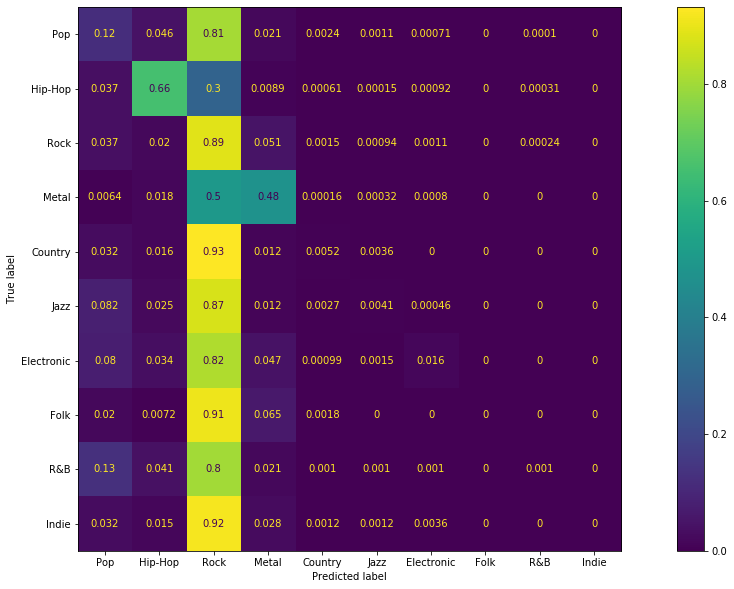

In [60]:
plt.rcParams['figure.figsize'] = [20,10]
sklearn.metrics.plot_confusion_matrix(best_both_clfs['LogisticRegression'], 
                                      test_both_pca, lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_logistic_regression_both')

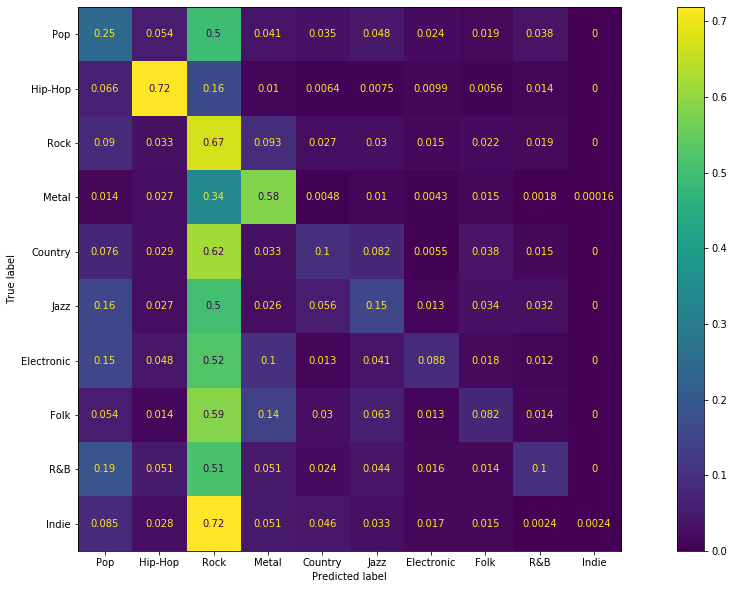

In [70]:
plt.rcParams['figure.figsize'] = [20,10]
sklearn.metrics.plot_confusion_matrix(best_both_clfs['RandomForest'], 
                                      test_both_pca, lyrics_1_test['genre'],
                                      display_labels=genre_dict.keys(),normalize='true')
plt.savefig('Pictures/confusion_matrix_random_forest_both')

In [61]:
from sklearn.inspection import permutation_importance

Best_LR = best_both_clfs['LogisticRegression']
Best_RF = best_both_clfs['RandomForest']
LR_feature_checking = permutation_importance(Best_LR, 
                                             test_both_pca, 
                                             lyrics_1_test['genre'], 
                                             scoring=f1_scorer, n_jobs=-1, 
                                             random_state=0, n_repeats=10)

In [62]:
RF_feature_checking = permutation_importance(Best_RF, 
                                             test_both_pca, 
                                             lyrics_1_test['genre'], 
                                             scoring=f1_scorer, n_jobs=-1, 
                                             random_state=0, n_repeats=10)

In [63]:
sorted(enumerate(LR_feature_checking['importances_mean']),key=lambda x:x[1],reverse=True)[:10]
# 20-repetity; 21-sentiment

[(1, 0.06007702145270667),
 (0, 0.05271083203111733),
 (3, 0.03588848271669172),
 (11, 0.012423781680895219),
 (10, 0.011864539025919368),
 (9, 0.009009011265738675),
 (4, 0.008606490972405257),
 (5, 0.008326280486176013),
 (6, 0.006422922917569973),
 (2, 0.004794524795911798)]

In [64]:
sorted(enumerate(RF_feature_checking['importances_mean']),key=lambda x:x[1],reverse=True)[:10]
# 20-repetity; 21-sentiment

[(1, 0.06490087970272476),
 (0, 0.03292687277680831),
 (3, 0.0242850482530937),
 (10, 0.022794952105777234),
 (11, 0.012742672945632439),
 (5, 0.005604670824678443),
 (6, 0.004862710932689651),
 (9, 0.004308334184814311),
 (7, 0.00286035430745214),
 (8, 0.0023754225079112346)]